Get List of Protein ID's

In [7]:
# Map Protein IDs to names
import pandas as pd
import numpy as np

# Define the path to the CSV file
CSV_PATH = "/home/lcornelis/code/proteo/proteo/datasets/data/ALLFTD_dataset_for_nina_louisa.csv"
def get_protein_ids():
        print("Loading data from:", CSV_PATH)
        csv_data = pd.read_csv(CSV_PATH)
        has_plasma = csv_data.iloc[:, 9].astype(int)
        has_plasma = has_plasma == 1  # Converting from indices to boolean
        nfl = csv_data.loc[has_plasma, csv_data.columns[8]].astype(float)
        nfl_mask = ~np.isnan(nfl)

        # Extract the protein column names
        plasma_protein_cols = csv_data.columns[10 : 7299]
    
        # Extract and convert the plasma_protein values for rows where has_plasma is True and nfl is not NaN
        plasma_protein = csv_data.loc[has_plasma, plasma_protein_cols][nfl_mask].astype(float)

        protein_column_names = plasma_protein.columns
        
        return protein_column_names

protein_ids = get_protein_ids()
print(len(protein_ids))

Loading data from: /home/lcornelis/code/proteo/proteo/datasets/data/ALLFTD_dataset_for_nina_louisa.csv
7289


Create Explainer and run on every person

conv1 is:GATConv(1, 8, heads=4)
conv2 is:GATConv(32, 16, heads=3)


89
n_nodes = 7289
Number of patients 89
Counter({'REG3A|Q06141^SL002648@seq.9277.16|PLASMA': 16, 'RNASE4|P34096|PLASMA': 15, 'ME1|P48163|PLASMA': 14, 'SDCBP|O00560|PLASMA': 13, 'TPT1|P13693^SL005679@seq.3872.2|PLASMA': 12, 'EIF5|P55010|PLASMA': 12, 'HTN3|P15516|PLASMA': 12, 'IL18R1|Q13478^SL004152@seq.14079.14|PLASMA': 12, 'TIMP1|P01033^SL000591@seq.2211.9|PLASMA': 12, 'NELL1|Q92832|PLASMA': 12, 'RAB3IL1|Q8TBN0|PLASMA': 12, 'WRNIP1|Q96S55|PLASMA': 12, 'B2M|P61769^SL000283@seq.10574.10|PLASMA': 11, 'FLNA|P21333^SL025862@seq.11171.25|PLASMA': 11, 'PIP4K2B|P78356^SL011212@seq.18232.42|PLASMA': 11, 'EWSR1|Q01844|PLASMA': 11, 'GHRL|Q9UBU3^SL023012@seq.23581.131|PLASMA': 11, 'FTH1|P02794^SL007933@seq.25913.17|PLASMA': 11, 'DDX19B|Q9UMR2|PLASMA': 11, 'FCGBP|Q9Y6R7|PLASMA': 11, 'ITIH4|Q14624|PLASMA': 11, 'SLC6A16|Q9GZN6|PLASMA': 11, 'BCAP31|P51572|PLASMA': 11, 'VEGFA|P15692^SL003310@seq.14032.2|PLASMA': 11, 'NDP|Q00604|PLASMA': 11, 'TFPI|P10646|PLASMA': 11, 'EPHA2|P29317|PLASMA': 11, 'IGFBP2|P

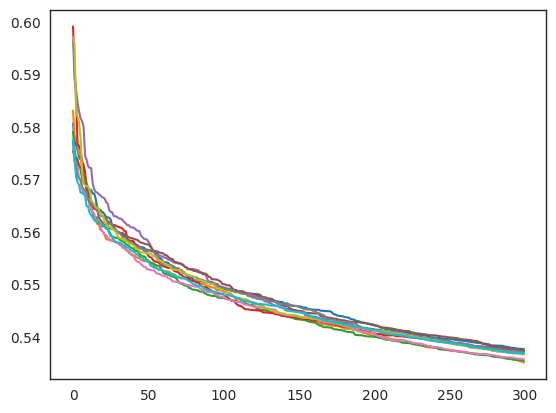

In [21]:
# Compute explainer for each person in the dataset
import os
import torch
import torch_geometric
from torch_geometric.explain import GNNExplainer, Explainer
from main import Proteo, AttrDict
from proteo.datasets.ftd import ROOT_DIR, FTDDataset
from config_utils import CONFIG_FILE, read_config_from_file
from models.gat_v4 import GATv4
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter



#Load model checkpoint
module = Proteo.load_from_checkpoint("/home/lcornelis/code/proteo/proteo/checkpoints/ckpt14-05-2024epoch=41.ckpt")

# Load datasets
root = os.path.join(ROOT_DIR, "data", "ftd")
config = read_config_from_file(CONFIG_FILE)
model_parameters = getattr(config, config.model)
model_parameters = AttrDict(model_parameters)
test_dataset = FTDDataset(root, "test", config)
train_dataset = FTDDataset(root, "train", config)

# Choose dataset
dataset = test_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Construct Explainer and set parameters
explainer = Explainer(
model=module.model.to(device),
algorithm=GNNExplainer(epochs=5),
explanation_type='model',
model_config=dict(
    mode='regression',
    task_level='graph',  # Explain why the model predicts a certain property or label for the entire graph (nodes + edges)
    return_type='raw'
),
node_mask_type='object', # Generate masks that indicate the importance of individual node features
edge_mask_type=None,
threshold_config=dict(
    threshold_type='topk',
    value=300,
),
)



# Run explainer on each person in dataset
i = 0 
all_proteins = []
print(len(dataset))
n_nodes = len(dataset[0].x)
print(f"n_nodes = {n_nodes}")
# Initialize sum_node_importance as a dictionary with protein_ids as keys
sum_node_importance = {protein_id: 0 for protein_id in protein_ids}

for data in dataset:
    data_attributes = data.keys
    # Ensure data.x and data.edge_index are tensors
    if not isinstance(data.x, torch.Tensor) or not isinstance(data.edge_index, torch.Tensor):
        raise TypeError("data.x and data.edge_index must be torch.Tensor")
    #print(f'Batch actual attributes: {data_attributes}')
    explanation = explainer(
        data.x,
        data.edge_index,
        data=data,
        target=None,
        index=None
    )
    #print(f'Generated explanations in {explanation.available_explanations}')
    # Node_importance is of format [[0], [0],[0],...,[.5]] with length equal to the number of nodes
    node_importance = explanation.node_mask.cpu().detach().numpy()
    if i < 10:
        plt.plot(sorted(node_importance, reverse=True)[:300])

    # Find row indices of non-zero elements in node_importance
    indv_important_proteins_indices = np.nonzero(node_importance)[0]
    indv_important_proteins = protein_ids[indv_important_proteins_indices]
    
    all_proteins.append(indv_important_proteins) #array holding all the important proteins for each person

    # Update sum_node_importance dictionary using protein_ids as keys
    for idx, importance in enumerate(node_importance):
        protein_id = protein_ids[idx]
        sum_node_importance[protein_id] += importance[0]
        
    i += 1

print("Number of patients", i)
# Flatten the list of lists into a single list
full_count = [item for sublist in all_proteins for item in sublist]

# Use Counter to count the occurrences of each element
protein_count = Counter(full_count)
print(protein_count)
print(len(protein_count))


Plot Average Importance of Top Proteins

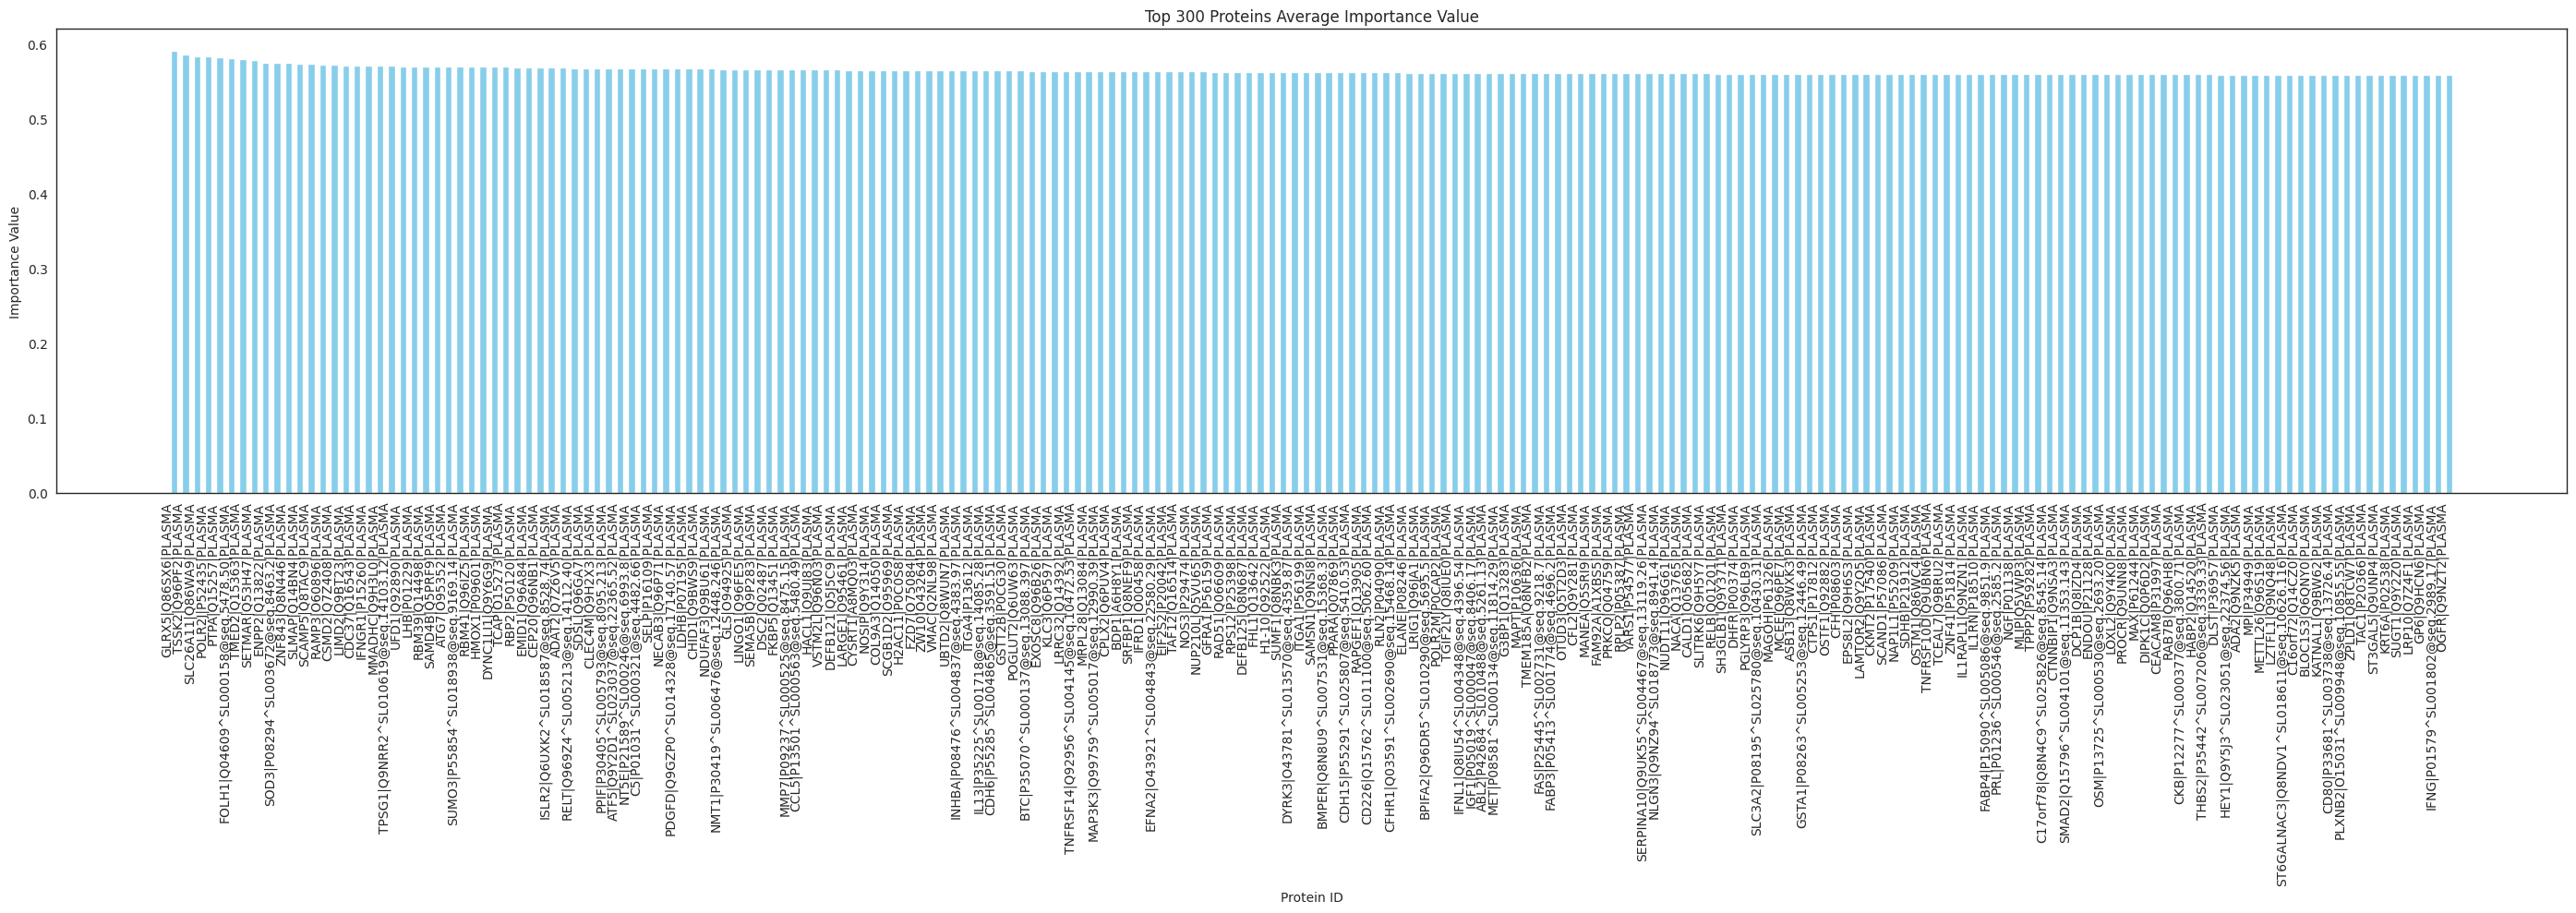

In [44]:
def divide_dict_values(dict1, dict2):
    result = {}
    for key in dict1:
        if key in dict2:
            if dict1[key] != 0:  # Avoid division by zero
                result[key] = dict2[key] / dict1[key]
            else:
                result[key] = None  # or handle division by zero as needed
    return result

sum_node_importance_avg = divide_dict_values(protein_count, sum_node_importance)

sorted_items = sorted(sum_node_importance_avg.items(), key=lambda x: x[1], reverse=True)
# Get the first 300 items (or less if there are fewer than 300 items)
top_300_items = sorted_items[:200]


def plot_a_dictionary(dict, title, x_label, y_label):
    # Separate the items into x and y components for plotting
    keys = [item[0] for item in dict]
    values = [item[1] for item in dict] # Value is a list of one object

    # Plot the data
    plt.figure(figsize=(28, 10))
    bar_width = 0.6
    plt.bar(keys, values, color='skyblue', width=bar_width)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90, ha='right')  # Rotate x-ticks for better readability
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    #plt.gca().invert_xaxis()  # Invert y-axis to have the highest values on top
    plt.show()


plot_a_dictionary(top_300_items, 'Top 300 Proteins Average Importance Value', 'Protein ID', 'Importance Value')


<class 'collections.Counter'>


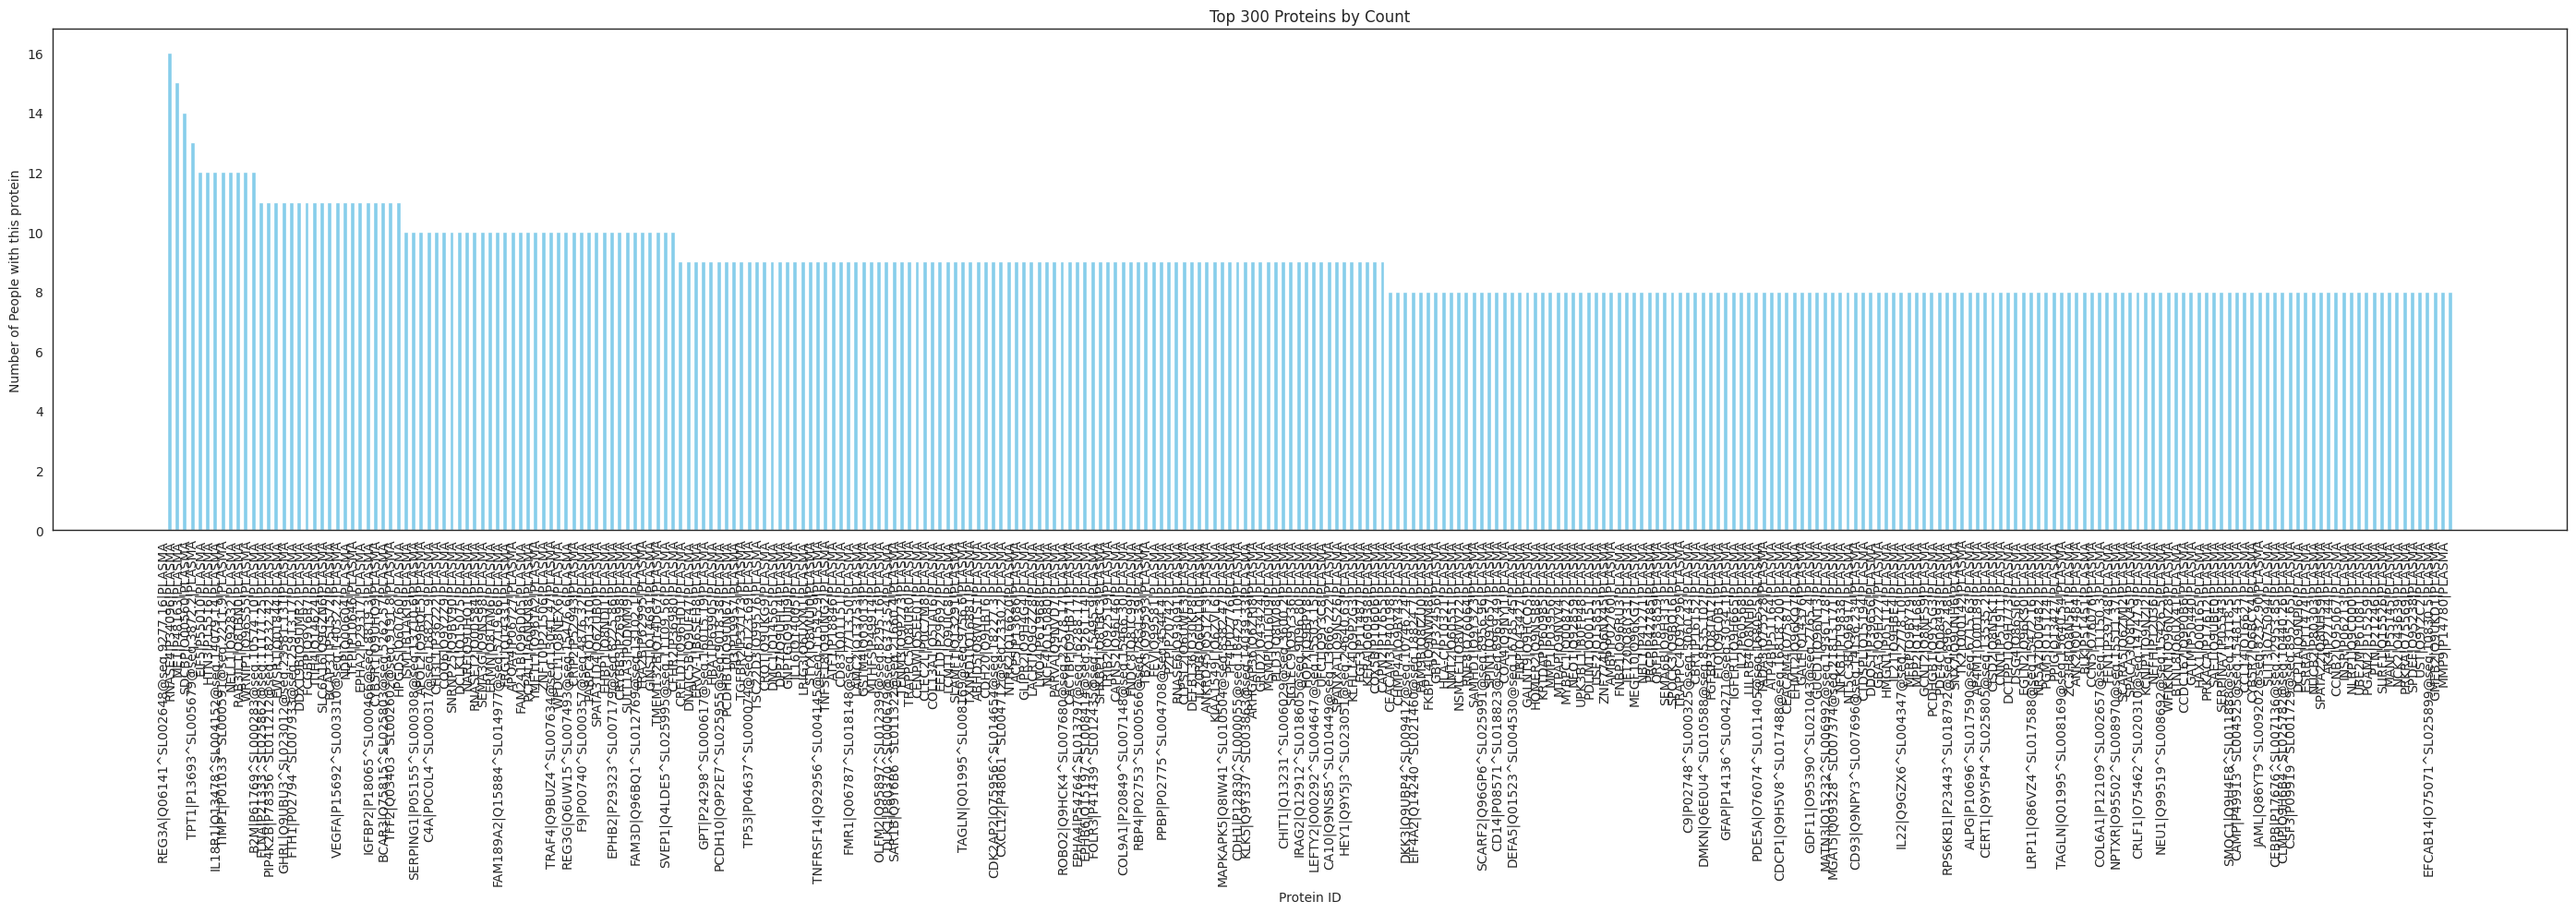

In [43]:
import matplotlib.pyplot as plt

print(type(protein_count))
sorted_proteins = sorted(protein_count.items(), key=lambda x: x[1], reverse=True)

top_300_count = sorted_proteins[:300]

plot_a_dictionary(top_300_count, 'Top 300 Proteins by Count', 'Protein ID', 'Number of People with this protein')

Find WGCNA Clusters

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  6137
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.628611 -0.930622       0.774962  586.547051  374.357936   
1       2   0.73949 -0.839783       0.956489  239.773855   71.531197   
2       3  0.817364 -0.799865       0.968549  139.649918   17.753762   
3       4  0.874339 -0.782453       0.968892   94.265611    5.458057   
4       5  0.908199 -0.784746        0.95725   68.560268    1.997544   
5       6   0.92714 -0.802024       0.944771   52.161658    0.843222   
6       7  0.942585  -0.82067       0.943414   40.920431    0.378143   
7       8  0.938895 -0.843951        0.92422   32.833747    0.183264   
8       9   0.93418 -0.863399       0.915385     26.8097    0.089957   
9      10  0.922563 -0.885622       0.903574   22.200989     0.04667   
10     11  0.907874 -0.912621       0.894529    18.59975     0.02322   
11     13  0.873799 -0.961059    

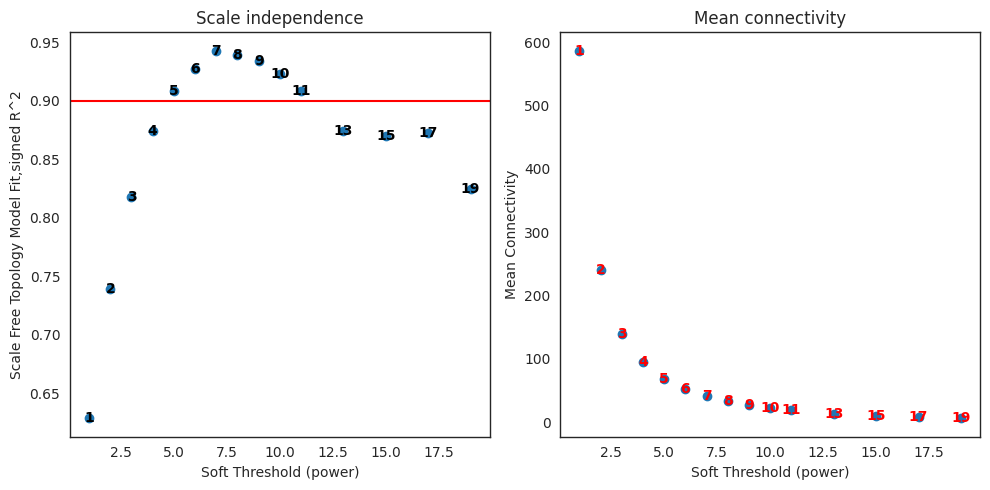

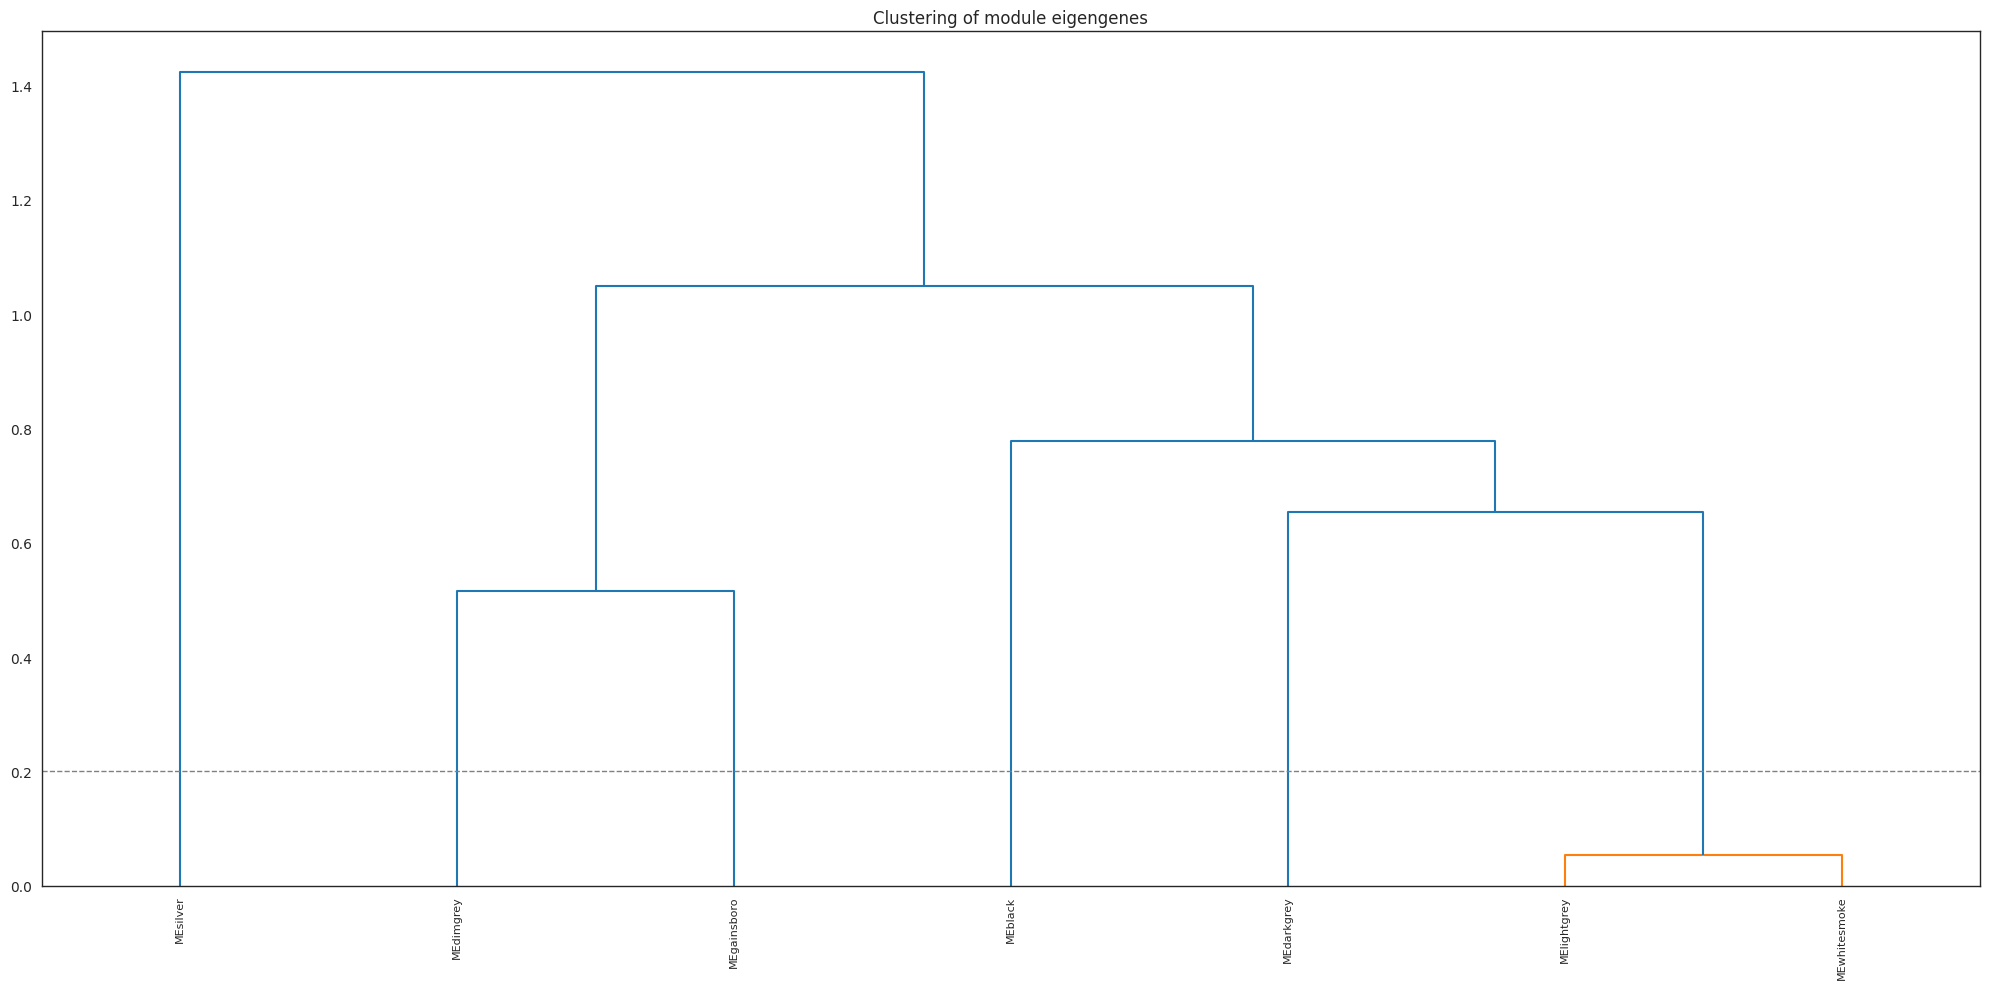

In [62]:
import pandas as pd
import PyWGCNA
from PyWGCNA import WGCNA

# Step 1: Load your data
# Assuming you have a CSV file with rows as proteins and columns as samples
csv_data = pd.read_csv(CSV_PATH)
has_plasma = csv_data.iloc[:, 9].astype(int)
has_plasma = has_plasma == 1  # Converting from indices to boolean
nfl = csv_data.loc[has_plasma, csv_data.columns[8]].astype(float)
nfl_mask = ~np.isnan(nfl)
# Extract the protein column names
plasma_protein_cols = csv_data.columns[10 : 7299]
    
# Extract and convert the plasma_protein values for rows where has_plasma is True and nfl is not NaN
plasma_protein = csv_data.loc[has_plasma, plasma_protein_cols][nfl_mask].astype(float)

# Step 2: Initialize WGCNA object
wgcna = WGCNA(name = "FTD_Dataset", species = "Human", geneExp= plasma_protein)

wgcna.findModules()

# Constructing dict of module names and the proteins in each module
module_names = wgcna.getModuleName()
module_dict = {}
for module in module_names:
    module_proteins = wgcna.getGeneModule(module)
    module_dict[module] = module_proteins



Plot Importance by WGCNA Cluster

In [84]:
print(module_dict['black']['black'].columns)
print(module_dict['black']['black']['dynamicColors'])
#print(module_dict['black']['black'])

Index(['dynamicColors', 'moduleColors', 'moduleLabels'], dtype='object')
A4GNT|Q9UNA3|PLASMA                          black
AACS|Q86V21|PLASMA                           black
AAGAB|Q6PD74|PLASMA                          black
AAMDC|Q9H7C9|PLASMA                          black
AARS1|P49588|PLASMA                          black
                                             ...  
ZNF696|Q9H7X3|PLASMA                         black
ZNRF3|Q9ULT6^SL018971@seq.10390.21|PLASMA    black
ZRANB1|Q9UGI0|PLASMA                         black
ZWINT|O95229|PLASMA                          black
ZYX|Q15942|PLASMA                            black
Name: dynamicColors, Length: 2980, dtype: object


array([[2.73296392],
       [1.08230257],
       [1.08526909],
       [2.18780655],
       [3.86089438],
       [1.10714352],
       [0.54976016],
       [1.68710524],
       [2.21770883],
       [1.08070755]])

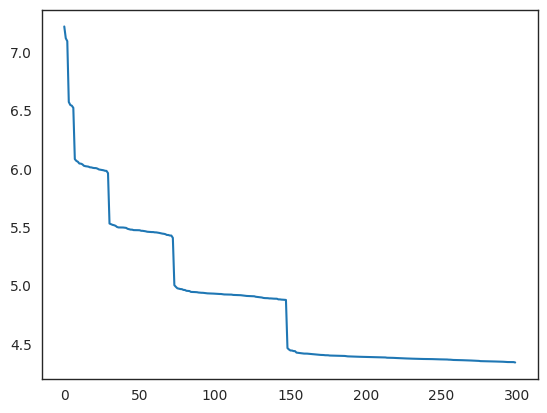

In [51]:
plt.plot(sorted(sum_node_importance, reverse=True)[:300])
sum_node_importance[:10]
print(sorted(node_importance, reverse=True)[:])